In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

import pims
import trackpy as tp

vid_path = "./data/videos/birdbath/vortex/"
vid_filename = "2024_0403_115801_028.MP4" # 2024_0417_181720_117, 2024_0412_130453_169, 2024_0415_103100_052, 2024_0415_190930_079
frames_filepaths = f"./data/images/{vid_filename.split('.')[0]}/"
zfill_ = 5

EXTRACT_FRAMES = False
if EXTRACT_FRAMES:
    os.makedirs(frames_filepaths, exist_ok=True)
    video = cv2.VideoCapture(f"{vid_path}{vid_filename}")
    frame_counter = 0
    while True:
        ret, frame = video.read()
        if not ret:
            break
        if frame_counter % 1 == 0:
            cv2.imwrite(f"{frames_filepaths}/frame_{str(frame_counter).zfill(zfill_)}.jpg", frame)  
        frame_counter += 1
    video.release()

def get_trajectory_stats(df_trajectories):
    
    """
    Obtain some basic statistics of trajectories to use for
    rejection and selection of trajectories for further processing
    """
    
    ctraj = df_trajectories
    particles = ctraj.particle.unique()

    print("number of particles = number of trajectories:", len(particles))

    stats = dict()
    frames_present = []

    for nth, prt in enumerate(particles):
        sub = ctraj[ctraj.particle == prt]
        
        if not sub.empty:
            x, y = sub.x, sub.y
            dx, dy = x.diff(), y.diff()
            
            stats[int(prt)] = {
                "particle" : prt,
                "x_avg" : x.mean(),
                "y_avg" : y.mean(),
                "x_std" : x.std(),
                "y_std" : y.std(),
                "travel_dist" : sum(np.sqrt(dx[1:] ** 2 + dy[1:] ** 2)),
                "frames_present" : sub["frame"].to_list(), 
                "first_frame" : sub["frame"].min(),
                "last_frame" : sub["frame"].max(),
                "nframes" : len(sub["frame"].unique()),
                "ep_mean" : sub["ep"].mean(),
                "ep_median" : sub["ep"].median(),
                "displacement_first_last" : np.sqrt((x.to_list()[-1] - x.to_list()[0]) ** 2 + (y.to_list()[-1] - y.to_list()[0]) ** 2)
        }
            frames_present.extend(sub["frame"].to_numpy())

    frames_present = np.array(frames_present)
    stats = pd.DataFrame.from_dict(stats, orient="index")
    
    return stats, frames_present

In [6]:
img_seq_folder = f"{frames_filepaths}/*.jpg"
frames = pims.as_grey(pims.open(img_seq_folder)) 
frame_shape = frames[0].shape
img_width = frames[0].shape[1]
img_height = frames[0].shape[0]

# Time vector
fps = 120
num_frames = len(frames)
time = np.linspace(0, num_frames / fps, num_frames)
tmax = max(time)
frames

(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /Users/mikehemberger/Documents/vscode/rotifer-locomotion/data/images/2024_0403_115801_028/*.jpg
    Length: 1588 frames
    Frame Shape: (720, 1280, 3)
    Pixel Datatype: uint8

In [8]:
subtract_frame_idx = 0
frame_step = 5
subtract_frame = frames[subtract_frame_idx]
process_frames = np.arange(subtract_frame_idx + 1, num_frames, step=frame_step)

zproj = []
for nth in process_frames:
    zproj.append(frames[nth] - subtract_frame)

zproj = np.stack(zproj)
zproj = np.min(zproj, axis=0)
print(np.min(zproj))

-178.87300000000002


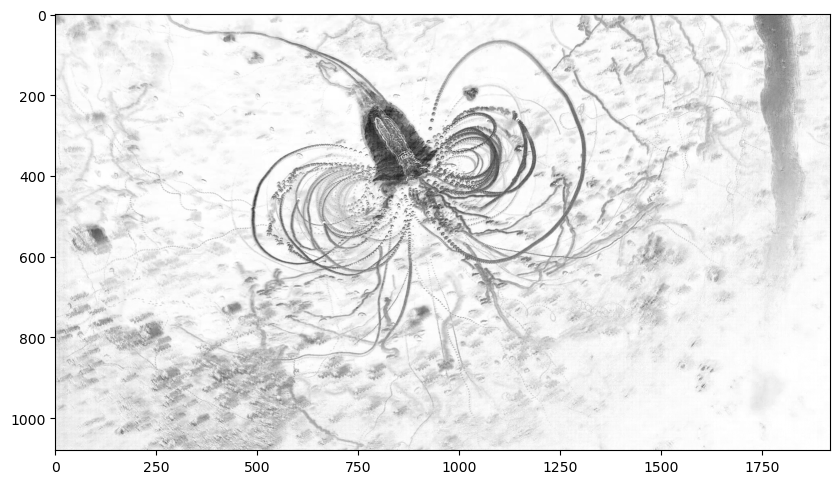

In [4]:
vmin_ = np.min(zproj) #+ 90
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(zproj, cmap="gray", vmin=vmin_, vmax=0)
fig.savefig(f"./data/results/vortex/{vid_filename.split('.')[0]}-zmin-proj_num_process_frames{process_frames[-1]}_frame-step{frame_step}_vmin{vmin_}.jpg", dpi=600)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(zproj, cmap="gray", vmin=np.min(zproj), vmax=0)
fig.savefig(f"./data/results/vortex/{vid_filename.split('.')[0]}-zmin-proj-zoomin_num_process_frames{process_frames[-1]}.jpg", dpi=600)
ax.set_xlim(200,500); ax.set_ylim(250,500)
ax.invert_yaxis()

In [ ]:
SAVE_NPY = True
if SAVE_NPY:
    np.save(f"./data/results/vortex/{vid_filename.split('.')[0]}_zmin-proj_num_process_frames{process_frames[-1]}.npy", zproj)
else:
    zproj = np.load(f"./data/results/vortex/{vid_filename.split('.')[0]}_zmin-proj_num_process_frames{process_frames[-1]}.npy")


In [ ]:
diameter = 5  # original 13
threshold = 5  # original 15
frame_nr = 0

# Location of features
f = tp.locate(frames[frame_nr], diameter, invert=True, threshold=threshold)  #, percentile=percentile)
print(len(f))

plt.figure(figsize=(6,6))
tp.annotate(f, frames[frame_nr], plot_style={"markersize" : 5});  # this shows the bandpass filtered image
# zoom in here multiple regions

f.head(5)

In [ ]:
# 2. Batch Process frames
tp.quiet()
f = tp.batch(frames[1000:], diameter, invert=True, threshold=threshold)  # , processes=1, minmass=150, separation=diameter*2
len(f)

In [ ]:
params = ["mass", "size", "ecc", "signal", "raw_mass", "ep"]

fig, ax = plt.subplots(1, 6, figsize=(19,2.5))
for nth, param in enumerate(params):
    ax[nth].hist(f[param], bins=100)
    ax[nth].set(xlabel=param, ylabel='count');

In [ ]:
tp.quiet()
max_displacement = 55  # 55 in px
particle_memory = 3
t = tp.link(f, max_displacement, memory=particle_memory, adaptive_stop=5, adaptive_step=.95)
print(len(t))
t.head()

In [ ]:

lasts_num_frames = 20  # 30
t1 = tp.filter_stubs(t, lasts_num_frames)
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

stats, frames_present = get_trajectory_stats(t1)
stats

In [ ]:
# This plots trajectories with associated particle number
fig, ax = plt.subplots(figsize=(25,25))
tp.plot_traj(t1, superimpose=frames[frame_nr], label=True, ax=ax);
fig, ax = plt.subplots(figsize=(10,5))
tp.scatter(t1, ax=ax, plot_style={"ms" : 2, "alpha" : .1, "color" : "k", "label" : "accepted"})